In [85]:
import torch
from torch import nn,optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchtext.datasets import AG_NEWS
from IPython.display import clear_output
from itertools import count
# Get cpu, gpu or mps device for training.
device = (
    "cuda" 
    if torch.cuda.is_available() else "mps"
    if torch.backends.mps.is_available() else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [86]:
word_num = 0
n = 120000
for i,(_, sentence) in zip(count(1),AG_NEWS(split='train')):
    word_num += len(sentence)
word_num / i,i

(236.477525, 120000)

In [87]:
for type_num, sentence in AG_NEWS(split='train'):
    print(type_num)
    print(sentence)
    break

3
Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.


In [88]:
from functools import reduce
chars = reduce(lambda x,y: set(x).union(set(y)),
               (sent for type,sent in AG_NEWS(split='train')))

In [89]:
chars = sorted(list(chars))
str_to_idx = {c:i+1 for i,c in enumerate(chars)}
str_to_idx['<S>'] = 0
idx_to_str = {i:c for c,i in str_to_idx.items()}
len(str_to_idx)

83

In [90]:
seq_len = 200
block_size = seq_len
embed_sz = 10
hidden_sz = 20
vocab_size = len(str_to_idx)

In [91]:
from itertools import cycle

train_dataset = cycle(AG_NEWS(split='train'))
test_dataset = cycle(AG_NEWS(split='test'))
def contextualize(sentence):
    X, Y = [],[]
    context = [0] * block_size
    for ch in list(sentence) + ['<S>']:
        ix = str_to_idx[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]
    return torch.tensor(X).to(device),torch.tensor(Y).to(device)


for new_type,sent in train_dataset:
    clear_output()
    print(sent, len(sent))
    X,y = contextualize(sent)
    print(X.shape, y.shape)
    break

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again. 144
torch.Size([145, 200]) torch.Size([145])


# VALINA RNN

In [92]:
block_size*hidden_sz

4000

In [93]:
class RNN_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Sequential(
            nn.Embedding(vocab_size,embed_sz),
            nn.Flatten(),
        )
        self.rnn = nn.LSTM(
            input_size = embed_sz,
            hidden_size = hidden_sz,
            num_layers = 2,
            batch_first = True,
            dropout = 0.5,
        )
        self.main = nn.Sequential(
            nn.Flatten(),
            nn.Linear(block_size*hidden_sz,1000,bias=False),
            nn.BatchNorm1d(1000),
            nn.Tanh(),
            
            nn.Linear(1000,300,bias=False),
            nn.BatchNorm1d(300),
            nn.Tanh(),
            
            nn.Linear(300, vocab_size,bias=False),
            nn.BatchNorm1d(vocab_size),
            nn.LogSoftmax(1),
        )
    def forward(self, x):
        x = self.embedding(x)
        x = x.view(x.size(0),block_size,embed_sz)
        x,h = self.rnn(x)
        x = self.main(x)
        return x

new_type,sent = next(train_dataset)
X,y = contextualize(sent)
model = RNN_Model().to(device)
print("--in--")
tmp = X[2:7]
# print(tmp)
print(tmp.shape)
out = model(tmp)
print("--out--")
# print(out)
print(out.shape)

--in--
torch.Size([5, 200])
--out--
torch.Size([5, 83])


In [94]:
# optimization configurations
loss_fn = nn.CrossEntropyLoss()
epochs = 5000
max_learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=max_learning_rate)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_learning_rate,
    total_steps=epochs*10,
)

In [95]:
train_lossi = []
test_lossi = []

In [96]:
for i in range(epochs):
    model.train()
    _,sent = next(train_dataset)
    X,y = contextualize(sent)

    # forward pass
    pred = model(X)
    loss = loss_fn(pred,y)
    
    # backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()
    
    # tracing
    train_lossi.append(loss.item())
    with torch.no_grad():
        _,sent = next(test_dataset)
        X,y = contextualize(sent)
        
        pred = model(X)
        loss = loss_fn(pred,y)
        test_lossi.append(loss.item())
    
    if i % 1000 == 0:
        print(i,loss.item())

0 4.925996780395508
1000 3.634927988052368
2000 2.8751778602600098
3000 2.6576790809631348
4000 2.5337982177734375


In [97]:
with torch.no_grad():
    _,sent = next(test_dataset)
    X,y = contextualize(sent)
    pred = model(X)
    loss = loss_fn(pred,y)
    print(loss.item())

2.399808883666992


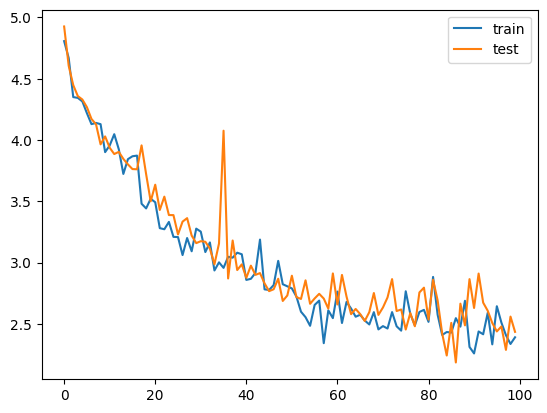

In [98]:
k = 50
plt.plot(train_lossi[::k],label='train')
plt.plot(test_lossi[::k],label='test')
plt.legend()

In [99]:
g = torch.Generator(device).manual_seed(42)
model.eval()
for _ in range(5):
    out = []
    context = [0] * block_size
    while True:
        logits = model(torch.tensor(context).to(device).view(1,-1))
        ix = torch.multinomial(logits.exp(),num_samples=1,generator=g).item()
        context = context[1:] +[ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(idx_to_str[i] for i in out))

Nisc necBlan 10 Fome Coukt of Hoves the remleroucits the nelies flaq depalal es of wordicions retarle Shaqy a sututer #39;s smosites wor Rrofpande on croties Qeaster ons will in To lemenesd oncurald is the fhad wite \atslew raye theuns, -s peogude of Cosenen/ed the, the Garecdusanin. <S>
Fhuristerecatamion preesset Goring \RIC. ZOP SFRelgurqate on Theshleself mebpe-arpei bisen, orO and of Clie whe coe mincede wladam Iniin agation agDFest  .39 fharedt toatarez-tadks onfo Gaiduatunathaly Juceirslile that (CE6.NN fagheL on treYC6.0 <S>
RKuded Sagacpeg riin syibas inal nEadXoq IryKO, Retumide Conskdralalay flitule presadloved ot, of of Beeray, ib berutite dusad colledod is Vomrity as to to2 ure os Famcund set an fe hey tut trreese P33..<S>
Gang Bonetieg as Con piale of Palenfs Sescy Ialliens peray to Bike folay hes Maqy meadcect Ousstared its leok hily the gryape of the Akiqecors deranced the barndifes kasers on the In'l. Hon<S>
Aghans UTror0 on Fl! SiPcLe Heral: sh\RtO Cills Ilavales enbu